In [ ]:
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense
from keras.utils import to_categorical

In [ ]:
batch_size = 128
num_epochs = 20
hidden_size = 512

In [ ]:
num_train = 60000
num_test = 10000

height, width, depth = 28, 28, 1
num_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(num_train, height * width)
X_test = X_test.reshape(num_test, height * width)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


# Определение архитектуры LeNet-5
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.pool1 = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.AvgPool2d(2, stride=2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = self.pool1(x)
        x = torch.sigmoid(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


batch_size = 64
learning_rate = 0.001
num_epochs = 10


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)


        outputs = model(images)
        loss = criterion(outputs, labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')






100%|██████████| 9.91M/9.91M [00:00<00:00, 50.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.34MB/s]


Epoch [1/10], Step [100/938], Loss: 2.2804
Epoch [1/10], Step [200/938], Loss: 1.4478
Epoch [1/10], Step [300/938], Loss: 0.8792
Epoch [1/10], Step [400/938], Loss: 0.6966
Epoch [1/10], Step [500/938], Loss: 0.4309
Epoch [1/10], Step [600/938], Loss: 0.4434
Epoch [1/10], Step [700/938], Loss: 0.4522
Epoch [1/10], Step [800/938], Loss: 0.2466
Epoch [1/10], Step [900/938], Loss: 0.1861
Epoch [2/10], Step [100/938], Loss: 0.2797
Epoch [2/10], Step [200/938], Loss: 0.3210
Epoch [2/10], Step [300/938], Loss: 0.2016
Epoch [2/10], Step [400/938], Loss: 0.1405
Epoch [2/10], Step [500/938], Loss: 0.1299
Epoch [2/10], Step [600/938], Loss: 0.1847
Epoch [2/10], Step [700/938], Loss: 0.3228
Epoch [2/10], Step [800/938], Loss: 0.1909
Epoch [2/10], Step [900/938], Loss: 0.2159
Epoch [3/10], Step [100/938], Loss: 0.1698
Epoch [3/10], Step [200/938], Loss: 0.1159
Epoch [3/10], Step [300/938], Loss: 0.1652
Epoch [3/10], Step [400/938], Loss: 0.3037
Epoch [3/10], Step [500/938], Loss: 0.1234
Epoch [3/10

Accuracy on test images: 98.37%


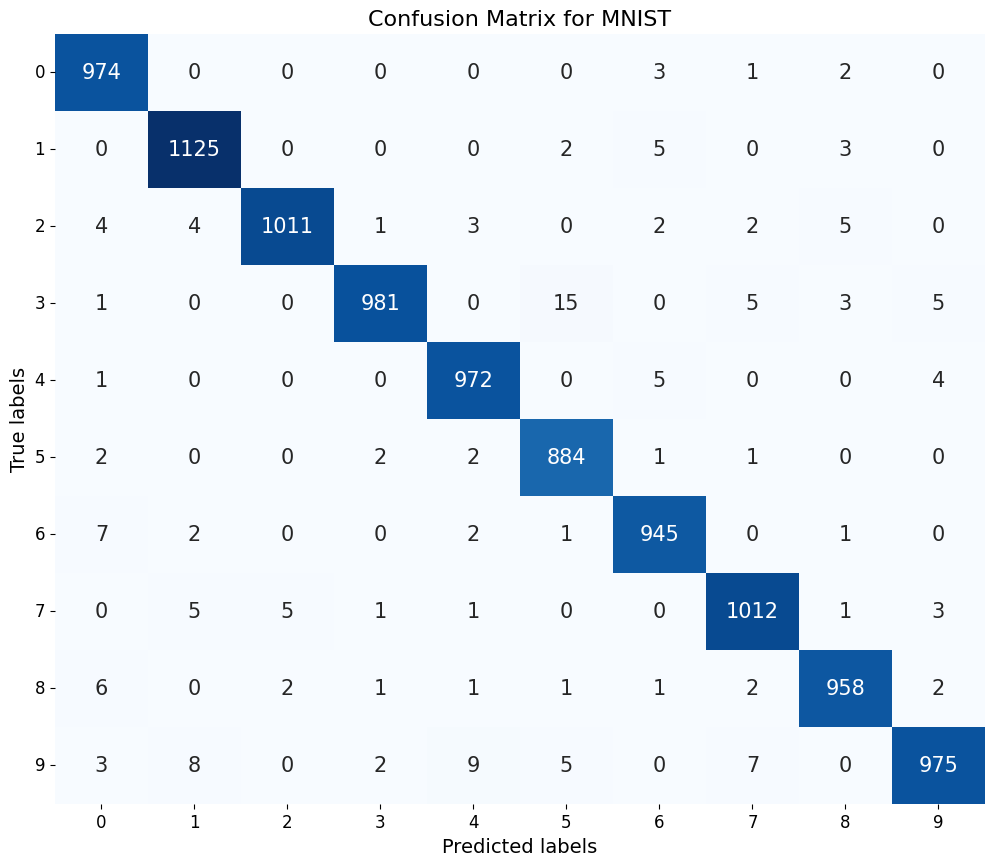

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Сохраняем метки и предсказания
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy on test images: {100 * correct / total:.2f}%')

# Построение матрицы ошибок
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            annot_kws={'size': 15})

plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix for MNIST', fontsize=16)
plt.xticks(np.arange(10) + 0.5, labels=np.arange(10), fontsize=12)
plt.yticks(np.arange(10) + 0.5, labels=np.arange(10), fontsize=12, rotation=0)
plt.show()

In [ ]:
import numpy as np
from typing import List
from scipy.special import softmax
from numpy.core.multiarray import array as array
from tqdm.notebook import tqdm

<ipython-input-1-ad210f2585d1>:4: DeprecationWarning: numpy.core.multiarray is deprecated and has been renamed to numpy._core.multiarray. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.array.
  from numpy.core.multiarray import array as array


In [ ]:
class ReLU():
    def __init__(self):
        self.training = False

    def train(self):
        pass
    def eval(self):
        pass
    def compute_output(self, input: np.array) -> np.array:
        return np.where(input > 0, input, 0)
    def __call__(self, input: np.array, *args, **kwargs) -> np.array:
        return self.forward(input, *args, **kwargs)

    def forward(self, input: np.array, *args, **kwargs) -> np.array:
        self.output = self.compute_output(input, *args, **kwargs)
        return self.output

    def backward(self, input: np.array, *args, **kwargs) -> np.array:
        grad_input = self.compute_grad_input(input, *args, **kwargs)
        self.update_grad_parameters(input, *args, **kwargs)
        return grad_input

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output * np.where(input > 0, 1, 0)

    def zero_grad(self):
        pass
    def update_grad_parameters(self, input, *args, **kwargs):
        pass
    def parameters(self) -> List[np.array]:
        return []

    def parameters_grad(self) -> List[np.array]:
        return []

class Tanh():
    def train(self):
        pass
    def eval(self):
        pass
    def __init__(self):
        self.training = False
    def __call__(self, input: np.array, *args, **kwargs) -> np.array:
        return self.forward(input, *args, **kwargs)

    def forward(self, input: np.array, *args, **kwargs) -> np.array:
        self.output = self.compute_output(input, *args, **kwargs)
        return self.output

    def backward(self, input: np.array, *args, **kwargs) -> np.array:
        grad_input = self.compute_grad_input(input, *args, **kwargs)
        self.update_grad_parameters(input, *args, **kwargs)
        return grad_input

    def compute_output(self, input: np.array) -> np.array:
        return np.tanh(input)
    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output * (1 - (self.compute_output(input) ** 2))

    def zero_grad(self):
        pass
    def update_grad_parameters(self, input, *args, **kwargs):
        pass
    def parameters(self) -> List[np.array]:
        return []

    def parameters_grad(self) -> List[np.array]:
        return []

In [ ]:
class Linear():
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        self.in_features = in_features
        self.out_features = out_features
        self.weight = np.random.uniform(-1, 1, (out_features, in_features)) / np.sqrt(in_features)
        self.bias = np.random.uniform(-1, 1, out_features) / np.sqrt(in_features) if bias else None

        self.grad_weight = np.zeros_like(self.weight)
        self.grad_bias = np.zeros_like(self.bias) if bias else None
        self.training = True
    def train(self):
        self.training = True
    def __call__(self, input: np.array, *args, **kwargs) -> np.array:
        return self.forward(input, *args, **kwargs)

    def forward(self, input: np.array, *args, **kwargs) -> np.array:
        self.output = self.compute_output(input, *args, **kwargs)
        return self.output

    def backward(self, input: np.array, *args, **kwargs) -> np.array:
        grad_input = self.compute_grad_input(input, *args, **kwargs)
        self.update_grad_parameters(input, *args, **kwargs)
        return grad_input

    def eval(self):
        self.training = False

    def compute_output(self, input: np.array) -> np.array:
        if self.bias is not None:
            return input @ self.weight.T + self.bias
        return input @ self.weight.T

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output @ self.weight

    def update_grad_parameters(self, input: np.array, grad_output: np.array):
        if self.bias is not None:
            self.grad_bias += np.sum(grad_output, axis = 0)
        self.grad_weight += grad_output.T @ input

    def zero_grad(self):
        self.grad_weight.fill(0)
        if self.bias is not None:
            self.grad_bias.fill(0)

    def parameters(self) -> List[np.array]:
        if self.bias is not None:
            return [self.weight, self.bias]
        return [self.weight]

    def parameters_grad(self) -> List[np.array]:
        if self.bias is not None:
            return [self.grad_weight, self.grad_bias]
        return [self.grad_weight]

    def __repr__(self) -> str:
        out_features, in_features = self.weight.shape
        return f'Linear(in_features={in_features}, out_features={out_features}, ' \
               f'bias={not self.bias is None})'

In [ ]:
class Conv2d():
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, bias: bool = True):
        self.weight = np.random.uniform(-1, 1, (out_channels, in_channels, kernel_size, kernel_size)) / np.sqrt(in_channels * kernel_size * kernel_size)
        self.bias = np.random.uniform(-1, 1, out_channels) / np.sqrt(in_channels * kernel_size * kernel_size) if bias else None
        self.grad_weight = np.zeros_like(self.weight)
        self.grad_bias = np.zeros_like(self.bias) if bias else None
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = 1
        self.cache = None
        self.training = True
    def train(self):
        self.training = True
    def __call__(self, input: np.array, *args, **kwargs) -> np.array:
        return self.forward(input, *args, **kwargs)

    def forward(self, input: np.array, *args, **kwargs) -> np.array:
        self.output = self.compute_output(input, *args, **kwargs)
        return self.output

    def backward(self, input: np.array, *args, **kwargs) -> np.array:
        grad_input = self.compute_grad_input(input, *args, **kwargs)
        self.update_grad_parameters(input, *args, **kwargs)
        return grad_input

    def eval(self):
        self.training = False

    def getWindows(self, input: np.array, output_size: int, kernel_size: int, padding: int = 0, stride: int = 1, dilate: int = 0):
        working_input = input
        working_pad = padding
        if dilate != 0:
            working_input = np.insert(working_input, range(1, input.shape[2]), 0, axis=2)
            working_input = np.insert(working_input, range(1, input.shape[3]), 0, axis=3)

        if working_pad != 0:
            working_input = np.pad(working_input, pad_width=((0,), (0,), (working_pad,), (working_pad,)), mode='constant', constant_values=(0.,))

        _, _, out_h, out_w = output_size
        out_b, out_c, _, _ = input.shape
        batch_str, channel_str, kern_h_str, kern_w_str = working_input.strides
        return np.lib.stride_tricks.as_strided(
            working_input,
            (out_b, out_c, out_h, out_w, kernel_size, kernel_size),
            (batch_str, channel_str, stride * kern_h_str, stride * kern_w_str, kern_h_str, kern_w_str)
        )
    def compute_output(self, input: np.array) -> np.array:
        n, c, h, w = input.shape
        out_h = (h - self.kernel_size) // self.stride + 1
        out_w = (w - self.kernel_size) // self.stride + 1
        windows = self.getWindows(input, (n, c, out_h, out_w), self.kernel_size, 0, self.stride)
        out = np.einsum('bihwkl,oikl->bohw', windows, self.weight)
        if self.bias is not None:
            out += self.bias[None, :, None, None]
        self.cache = windows
        return out
    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        padding = self.kernel_size - 1
        dout_windows = self.getWindows(grad_output, input.shape, self.kernel_size, padding = padding, stride = 1, dilate = self.stride - 1)
        rot_kern = np.rot90(self.weight, 2, axes=(2, 3))
        return np.einsum('bohwkl,oikl->bihw', dout_windows, rot_kern)

    def update_grad_parameters(self, input: np.array, grad_output: np.array):
        windows = self.cache
        self.grad_weight += np.einsum('bihwkl,bohw->oikl', windows, grad_output)
        if self.grad_bias is not None:
            self.grad_bias += np.sum(grad_output, axis = (0, 2, 3))
    def zero_grad(self):
        self.grad_weight.fill(0)
        if self.bias is not None:
            self.grad_bias.fill(0)

    def parameters(self) -> List[np.array]:
        if self.bias is not None:
            return [self.weight, self.bias]
        return [self.weight]

    def parameters_grad(self) -> List[np.array]:
        if self.bias is not None:
            return [self.grad_weight, self.grad_bias]
        return [self.grad_weight]

    def __repr__(self) -> str:
        return f'Conv2d(in_channels={self.in_channels}, out_channels={self.out_channels}, kernel_size={self.kernel_size} ' \
               f'bias={not self.bias is None})'

In [ ]:
class AvgPool2d():
    def __init__(self, kernel_size : int):
        self.kernel_size = kernel_size

        self.training = True
    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def compute_output(self, input: np.array) -> np.array:
        return input.reshape(input.shape[0], input.shape[1], input.shape[2] // self.kernel_size, self.kernel_size, input.shape[3] // self.kernel_size,
                             self.kernel_size).mean(axis = (3,5))

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        desired_shape = np.repeat(grad_output, 2, axis=2)
        return np.repeat(desired_shape, 2, axis=3) * (1 / (self.kernel_size * self.kernel_size))

    def __repr__(self) -> str:
        return f'AvgPool2d(kernel_size={self.kernel_size})'
    def __call__(self, input: np.array, *args, **kwargs) -> np.array:
        return self.forward(input, *args, **kwargs)

    def forward(self, input: np.array, *args, **kwargs) -> np.array:
        self.output = self.compute_output(input, *args, **kwargs)
        return self.output

    def backward(self, input: np.array, *args, **kwargs) -> np.array:
        grad_input = self.compute_grad_input(input, *args, **kwargs)
        self.update_grad_parameters(input, *args, **kwargs)
        return grad_input

    def zero_grad(self):
        pass
    def update_grad_parameters(self, input, *args, **kwargs):
        pass
    def parameters(self) -> List[np.array]:
        return []

    def parameters_grad(self) -> List[np.array]:
        return []

In [ ]:
class Sequential():
    def __init__(self, *args):
        self.modules = list(args)

    def compute_output(self, input: np.array) -> np.array:
        y = input
        for module in self.modules:
            y = module(y)
        return y

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        grad_input = grad_output
        for i in range(len(self.modules) - 1, 0, -1):
            grad_input = self.modules[i].backward(self.modules[i-1].output, grad_input)
        return self.modules[0].backward(input, grad_input)

    def __getitem__(self, item):
        return self.modules[item]
    def __call__(self, input: np.array, *args, **kwargs) -> np.array:
        return self.forward(input, *args, **kwargs)

    def forward(self, input: np.array, *args, **kwargs) -> np.array:
        self.output = self.compute_output(input, *args, **kwargs)
        return self.output

    def backward(self, input: np.array, *args, **kwargs) -> np.array:
        grad_input = self.compute_grad_input(input, *args, **kwargs)
        self.update_grad_parameters(input, *args, **kwargs)
        return grad_input

    def train(self):
        for module in self.modules:
            module.train()

    def eval(self):
        for module in self.modules:
            module.eval()

    def zero_grad(self):
        for module in self.modules:
            module.zero_grad()

    def parameters(self) -> List[np.array]:
        return [parameter for module in self.modules for parameter in module.parameters()]

    def parameters_grad(self) -> List[np.array]:
        return [grad for module in self.modules for grad in module.parameters_grad()]

    def __repr__(self) -> str:
        repr_str = 'Sequential(\n'
        for module in self.modules:
            repr_str += ' ' * 4 + repr(module) + '\n'
        repr_str += ')'
        return repr_str
    def update_grad_parameters(self, input, *args, **kwargs):
        pass

In [ ]:
class Lenet5():
    def __init__(self):
        self.encoder = Sequential(
            Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5),
            ReLU(),
            AvgPool2d(2),
            Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            ReLU(),
            AvgPool2d(2),
            Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5)
        )
        self.head = Sequential(
            Linear(in_features = 120, out_features = 84),
            ReLU(),
            Linear(in_features = 84, out_features = 10),
        )
    def compute_output(self, input: np.array) -> np.array:
        out = self.encoder(input).reshape(input.shape[0], -1)
        return self.head(out)
    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return self.encoder.backward(input,
                                      self.head.backward(self.encoder.output.reshape(input.shape[0], -1), grad_output).reshape(self.encoder.output.shape))
    def train(self):
        self.head.train()
        self.encoder.train()

    def __call__(self, input: np.array, *args, **kwargs) -> np.array:
        return self.forward(input, *args, **kwargs)

    def forward(self, input: np.array, *args, **kwargs) -> np.array:
        self.output = self.compute_output(input, *args, **kwargs)
        return self.output

    def backward(self, input: np.array, *args, **kwargs) -> np.array:
        grad_input = self.compute_grad_input(input, *args, **kwargs)
        self.update_grad_parameters(input, *args, **kwargs)
        return grad_input

    def eval(self):
        self.encoder.eval()
        self.head.eval()

    def zero_grad(self):
        self.encoder.zero_grad()
        self.head.zero_grad()

    def parameters(self) -> List[np.array]:
        return self.encoder.parameters() + self.head.parameters()

    def __iter__(self) -> List[np.array]:
        return self.encoder.parameters() + self.head.parameters()


    def parameters_grad(self) -> List[np.array]:
        return self.encoder.parameters_grad() + self.head.parameters_grad()
    def update_grad_parameters(self, input, *args, **kwargs):
        pass

In [ ]:
class SGD():
    def __init__(self, module, lr: float = 1e-3, momentum: float = 0.0,
                 weight_decay: float = 0.0):
        self.module = module
        self.state = {}
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

    def zero_grad(self):
        self.module.zero_grad()

    def step(self):
        parameters = self.module.parameters()
        gradients = self.module.parameters_grad()
        if 'm' not in self.state:
            self.state['m'] = [np.zeros_like(param) for param in parameters]
        for param, grad, m in zip(parameters, gradients, self.state['m']):
            g = grad + self.weight_decay * param
            np.add(self.momentum * m, g, out = m)
            np.add(param, -self.lr * m, out = param)
    def update_grad_parameters(self, input, *args, **kwargs):
        pass
    def parameters(self) -> List[np.array]:
        return []

    def parameters_grad(self) -> List[np.array]:
        return []

In [ ]:
class CrossEntropyLoss():
    def __init__(self):
        super().__init__()
        self.log_softmax = LogSoftmax()

    def compute_output(self, input: np.array, target: np.array) -> float:
        return (-1 / input.shape[0]) * np.sum(input[np.arange(input.shape[0]), target] - np.log(np.sum(np.exp(input), axis = 1)))

    def compute_grad_input(self, input: np.array, target: np.array) -> np.array:
        return (-1 / input.shape[0]) * (np.where(np.arange(input.shape[1]) == target[:, None], 1, 0) - softmax(input, axis = 1))
    def __call__(self, input: np.array, *args, **kwargs) -> np.array:
        return self.forward(input, *args, **kwargs)

    def forward(self, input: np.array, *args, **kwargs) -> np.array:
        self.output = self.compute_output(input, *args, **kwargs)
        return self.output

    def backward(self, input: np.array, *args, **kwargs) -> np.array:
        grad_input = self.compute_grad_input(input, *args, **kwargs)
        self.update_grad_parameters(input, *args, **kwargs)
        return grad_input
    def update_grad_parameters(self, input, *args, **kwargs):
        pass
    def parameters(self) -> List[np.array]:
        return []

    def parameters_grad(self) -> List[np.array]:
        return []

In [ ]:
class LogSoftmax():
    def compute_output(self, input: np.array) -> np.array:
        return log_softmax(input, axis = 1)

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output - (np.sum(grad_output, axis = 1, keepdims = True) * softmax(input, axis = 1))
    def __call__(self, input: np.array, *args, **kwargs) -> np.array:
        return self.forward(input, *args, **kwargs)

    def forward(self, input: np.array, *args, **kwargs) -> np.array:
        self.output = self.compute_output(input, *args, **kwargs)
        return self.output

    def backward(self, input: np.array, *args, **kwargs) -> np.array:
        grad_input = self.compute_grad_input(input, *args, **kwargs)
        self.update_grad_parameters(input, *args, **kwargs)
        return grad_input
    def update_grad_parameters(self, input, *args, **kwargs):
        pass
    def parameters(self) -> List[np.array]:
        return []

    def parameters_grad(self) -> List[np.array]:
        return []

In [ ]:
model = Lenet5()
optimizer = SGD(model, lr = 0.01, momentum = 0.9)
criterion = CrossEntropyLoss()

In [ ]:
import torchvision.transforms as T
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader

In [ ]:
transform = T.Compose([T.ToTensor(), T.Resize((32,32))])
train_set = MNIST('.data', transform=transform, train = True, download = True)
test_set = MNIST('.data', transform=transform, train = False, download = True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 50.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.87MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.00MB/s]


In [ ]:
train_loader = DataLoader(train_set, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 64, shuffle = False)

In [ ]:
num_epochs = 1
pbar_epoch = tqdm(range(1, num_epochs + 1))
pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Train process")

for epoch in pbar_epoch:
    train_loss, train_accuracy = 0.0, 0.0
    model.train()

    for batch_index, data in pbar_train:
        images, labels = data
        images = images.detach().numpy()
        labels = labels.detach().numpy()
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        model.backward(images, criterion.backward(predictions, labels))
        optimizer.step()
        cur_accuracy = np.sum(predictions.argmax(axis=1) == labels)
        train_loss += loss * images.shape[0]
        train_accuracy += cur_accuracy
        pbar_train.set_postfix({'train loss': loss, 'train accuracy' : cur_accuracy / images.shape[0]})

    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in test_loader:
        images = images.detach().numpy()
        labels = labels.detach().numpy()
        predictions = model(images)
        loss = criterion(predictions, labels)
        test_loss += loss.item() * images.shape[0]
        test_accuracy += np.sum(predictions.argmax(axis=1) == labels)
    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    pbar_epoch.set_postfix({'train loss': train_loss, 'test loss': test_loss, 'train accuracy' : train_accuracy, 'test accuracy' : test_accuracy})

  0%|          | 0/1 [00:00<?, ?it/s]

Train process:   0%|          | 0/938 [00:00<?, ?it/s]

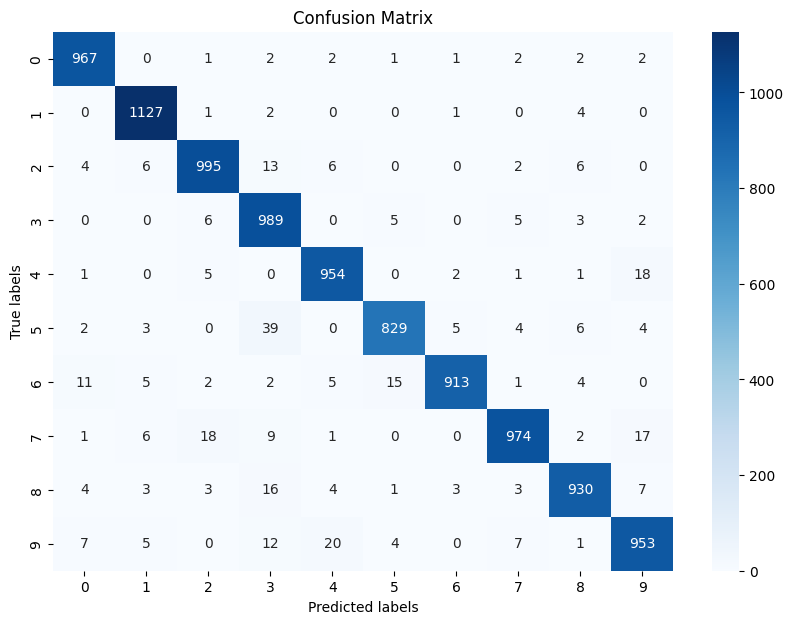

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
test_loss, test_accuracy = 0.0, 0.0
all_preds = []
all_labels = []
model.eval()

for images, labels in test_loader:
    images = images.detach().numpy()
    labels = labels.detach().numpy()
    predictions = model(images)
    loss = criterion(predictions, labels)

    test_loss += loss.item() * images.shape[0]
    batch_preds = predictions.argmax(axis=1)
    test_accuracy += np.sum(batch_preds == labels)

    # Сохраняем предсказания и метки для матрицы
    all_preds.extend(batch_preds)
    all_labels.extend(labels)

# Рассчитываем метрики
test_loss /= len(test_loader.dataset)
test_accuracy /= len(test_loader.dataset)

# Создаем и отображаем confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()